#### Import packages

In [1]:
import numpy as np
import pandas as pd
import csv
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
current_dir = os.getcwd()

#### Set variables

In [3]:
n_starts = 35
dataset = 'magic_carpet_2020'

#### Import behavioural dataset

In [ ]:
# Path to dataset

current_dir = os.getcwd()

if dataset == 'magic_carpet_2023':
    
    # Path to where the csv file is relative to the current script's directory
    path_to_data = os.path.abspath(os.path.join(current_dir, 
                                               '../../two_step_task_datasets/' + dataset + '_dataset/task_behaviour'))

    # Use glob to find all CSV files in the folder with the naming pattern
    file_paths = glob.glob(os.path.join(path_to_data, "*story.csv"))

elif dataset == 'magic_carpet_2020':
    
    # Path to where the csv file is relative to the current script's directory
    path_to_data = os.path.abspath(os.path.join(current_dir, 
                                               '../../two_step_task_datasets/' + dataset + '_dataset/choices'))


    
    # Use glob to find all CSV files in the folder with the naming pattern
    file_paths = glob.glob(os.path.join(path_to_data, "*game.csv"))

    
# Create an empty list to hold the dataframes
df_list = []

par_ids = []

# Loop through each file
for file_path in file_paths:
    # Extract the participant ID from the filename (assuming filename format like 001_story.csv)
    participant_id_str = os.path.basename(file_path).split('_')[0]
    
    participant_id = int(participant_id_str)

    if dataset == 'magic_carpet_2020' and participant_id == 4960: # Avoid outlier participant
        continue
        
    par_ids.append(participant_id)
    
    # Read the CSV file into a dataframe
    df = pd.read_csv(file_path)
    
    # Add the ParticipantID column
    df['ParticipantID'] = participant_id
    
    # Append the dataframe to the list
    df_list.append(df)

# Concatenate all dataframes into one
df_behavioural = pd.concat(df_list, ignore_index=True)

## Helper functions

In [5]:
def Compute_BIC_approx_LME(k, n, nll, ddm):
    # k: number of parameters
    # n: number of datapoints
    # nll: negative log-likelihood

    # The formula corresponds to the approximation LME ~ -BIC/2
    approx_lme = - ComputeBIC(k, n, nll,ddm)/2

    return approx_lme

def Compute_AIC_approx_LME(k, n, nll, ddm):
    # k: number of parameters
    # n: number of datapoints
    # nll: negative log-likelihood

    # The formula corresponds to the approximation LME ~ -AIC/2
    approx_lme = - ComputeAIC(k, n, nll,ddm)/2

    return approx_lme

def ComputeBIC(k, n, nll,ddm):
    # k: number of parameters
    # n: number of datapoints
    # nll: negative log-likelihood

    if (ddm):
        # Note that for models with ddm, nll is multiplied by a factor 2*n, because during the optimization procedure, nll is divided by that factor
        bic_score = k*np.log(n) + 2*nll*(2*n)
    else:
        bic_score = k*np.log(n) + 2*nll
     
    return bic_score

def ComputeAIC(k, n, nll, ddm):
    # k: number of parameters
    # n: number of datapoints
    # nll: negative log-likelihood

    if (ddm):
        # Note that for models with ddm, nll is multiplied by a factor 2*n, because during the optimization procedure, nll is divided by that factor
        aic_score = 2*(k + nll*(2*n))
    else:
        aic_score = 2*(k + nll)
     
    return aic_score

# Compare performance of classic Active Inference and Reinforcement Learning models 

#### Download fitted parameters

In [6]:
fitted_params_dir = "../model_fitting/fitted_parameters/" + dataset 

df_RL_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MRL_n_starts" + str(n_starts) + ".csv")
df_AI0_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MAI0_n_starts" + str(n_starts) + ".csv")
df_AI1_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MAI1_n_starts" + str(n_starts) + ".csv")
df_AI2_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MAI2_n_starts" + str(n_starts) + ".csv")
df_AI3_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MAI3_n_starts" + str(n_starts) + ".csv")

#### Calculate number of parameters per model

In [7]:
RL_k = len(df_RL_fitted_params.columns) - 2
AI0_k = len(df_AI0_fitted_params.columns) - 2
AI1_k = len(df_AI1_fitted_params.columns) - 2
AI2_k = len(df_AI2_fitted_params.columns) - 2
AI3_k = len(df_AI3_fitted_params.columns) - 2

#### Calculate BIC and AIC scores

In [8]:
par_ids = df_RL_fitted_params['ParticipantID'].values

column_names = ['ParticipantID','RL', 'AI0', 'AI1', 'AI2', 'AI3'] 

df_BIC = pd.DataFrame(np.nan, index=range(len(par_ids)), columns=column_names)
df_BIC['ParticipantID'] = par_ids

df_AIC = pd.DataFrame(np.nan, index=range(len(par_ids)), columns=column_names)
df_AIC['ParticipantID'] = par_ids

df_LME_BIC_approx = pd.DataFrame(np.nan, index=range(len(par_ids)), columns=column_names)
df_LME_BIC_approx['ParticipantID'] = par_ids

df_LME_AIC_approx = pd.DataFrame(np.nan, index=range(len(par_ids)), columns=column_names)
df_LME_AIC_approx['ParticipantID'] = par_ids

for par in par_ids:

    df_par = df_behavioural[df_behavioural['ParticipantID'] == par]

    T = len(df_par) 
    
    # Identify bad trials
    if dataset == 'magic_carpet_2020':
        badtrials_rt1 = np.where((df_par['rt1'] < 0.1) | (df_par['rt1'] == -1) | df_par['rt1'].isna())[0]
        badtrials_rt2 = np.where((df_par['rt2'] < 0.1) | (df_par['rt2'] == -1) | df_par['rt1'].isna())[0]
    if dataset == 'magic_carpet_2023':
        badtrials_rt1 = np.where((df_par['rt1'] < 0.1) | (df_par['rt1'] == "") | df_par['rt1'].isna())[0]
        badtrials_rt2 = np.where((df_par['rt2'] < 0.1) | (df_par['rt2'] == "") | df_par['rt1'].isna())[0]
        
    badtrials = np.concatenate((badtrials_rt1, badtrials_rt2))
    badtrials = np.sort(np.unique(badtrials))

    RL_NLL = df_RL_fitted_params[df_RL_fitted_params['ParticipantID'] == par]['NLL'].iloc[0]
    AI0_NLL = df_AI0_fitted_params[df_AI0_fitted_params['ParticipantID'] == par]['NLL'].iloc[0]
    AI1_NLL = df_AI1_fitted_params[df_AI1_fitted_params['ParticipantID'] == par]['NLL'].iloc[0]
    AI2_NLL = df_AI2_fitted_params[df_AI2_fitted_params['ParticipantID'] == par]['NLL'].iloc[0]
    AI3_NLL = df_AI3_fitted_params[df_AI3_fitted_params['ParticipantID'] == par]['NLL'].iloc[0]

    true_T = T - len(badtrials)
    
    df_BIC.loc[df_BIC['ParticipantID'] == par, 'RL'] = ComputeBIC(RL_k, true_T, RL_NLL, False)
    df_BIC.loc[df_BIC['ParticipantID'] == par, 'AI0'] = ComputeBIC(AI0_k, true_T, AI0_NLL, False)
    df_BIC.loc[df_BIC['ParticipantID'] == par, 'AI1'] = ComputeBIC(AI1_k, true_T, AI1_NLL, False)
    df_BIC.loc[df_BIC['ParticipantID'] == par, 'AI2'] = ComputeBIC(AI2_k,true_T, AI2_NLL, False)
    df_BIC.loc[df_BIC['ParticipantID'] == par, 'AI3'] = ComputeBIC(AI3_k,true_T, AI3_NLL, False)

    df_LME_BIC_approx.loc[df_LME_BIC_approx['ParticipantID'] == par, 'RL'] = Compute_BIC_approx_LME(RL_k, true_T, RL_NLL, False)
    df_LME_BIC_approx.loc[df_LME_BIC_approx['ParticipantID'] == par, 'AI0'] = Compute_BIC_approx_LME(AI0_k, true_T, AI0_NLL, False)
    df_LME_BIC_approx.loc[df_LME_BIC_approx['ParticipantID'] == par, 'AI1'] = Compute_BIC_approx_LME(AI1_k, true_T, AI1_NLL, False)
    df_LME_BIC_approx.loc[df_LME_BIC_approx['ParticipantID'] == par, 'AI2'] = Compute_BIC_approx_LME(AI2_k, true_T, AI2_NLL, False)
    df_LME_BIC_approx.loc[df_LME_BIC_approx['ParticipantID'] == par, 'AI3'] = Compute_BIC_approx_LME(AI3_k, true_T, AI3_NLL, False)

    df_LME_AIC_approx.loc[df_LME_AIC_approx['ParticipantID'] == par, 'RL'] = Compute_AIC_approx_LME(RL_k, true_T, RL_NLL, False)
    df_LME_AIC_approx.loc[df_LME_AIC_approx['ParticipantID'] == par, 'AI0'] = Compute_AIC_approx_LME(AI0_k, true_T, AI0_NLL, False)
    df_LME_AIC_approx.loc[df_LME_AIC_approx['ParticipantID'] == par, 'AI1'] = Compute_AIC_approx_LME(AI1_k, true_T, AI1_NLL, False)
    df_LME_AIC_approx.loc[df_LME_AIC_approx['ParticipantID'] == par, 'AI2'] = Compute_AIC_approx_LME(AI2_k, true_T, AI2_NLL, False)
    df_LME_AIC_approx.loc[df_LME_AIC_approx['ParticipantID'] == par, 'AI3'] = Compute_AIC_approx_LME(AI3_k, true_T, AI3_NLL, False)

    #df_BIC.loc[df_BIC['ParticipantID'] == par, 'RL'] = RL_NLL
    #df_BIC.loc[df_BIC['ParticipantID'] == par, 'AI0'] = AI0_NLL
    #df_BIC.loc[df_BIC['ParticipantID'] == par, 'AI1'] = AI1_NLL
    #df_BIC.loc[df_BIC['ParticipantID'] == par, 'AI2'] = AI2_NLL
    #df_BIC.loc[df_BIC['ParticipantID'] == par, 'AI3'] = AI3_NLL

    df_AIC.loc[df_AIC['ParticipantID'] == par, 'RL'] = ComputeAIC(RL_k, true_T, RL_NLL, False)
    df_AIC.loc[df_AIC['ParticipantID'] == par, 'AI0'] = ComputeAIC(AI0_k, true_T, AI0_NLL, False)
    df_AIC.loc[df_AIC['ParticipantID'] == par, 'AI1'] = ComputeAIC(AI1_k, true_T, AI1_NLL, False)
    df_AIC.loc[df_AIC['ParticipantID'] == par, 'AI2'] = ComputeAIC(AI2_k, true_T, AI2_NLL, False)
    df_AIC.loc[df_AIC['ParticipantID'] == par, 'AI3'] = ComputeAIC(AI3_k, true_T,AI3_NLL, False)

df_LME_BIC_approx.to_csv(current_dir + '/LMEs_BIC_approx.csv', index=False)
df_LME_AIC_approx.to_csv(current_dir + '/LMEs_AIC_approx.csv', index=False)

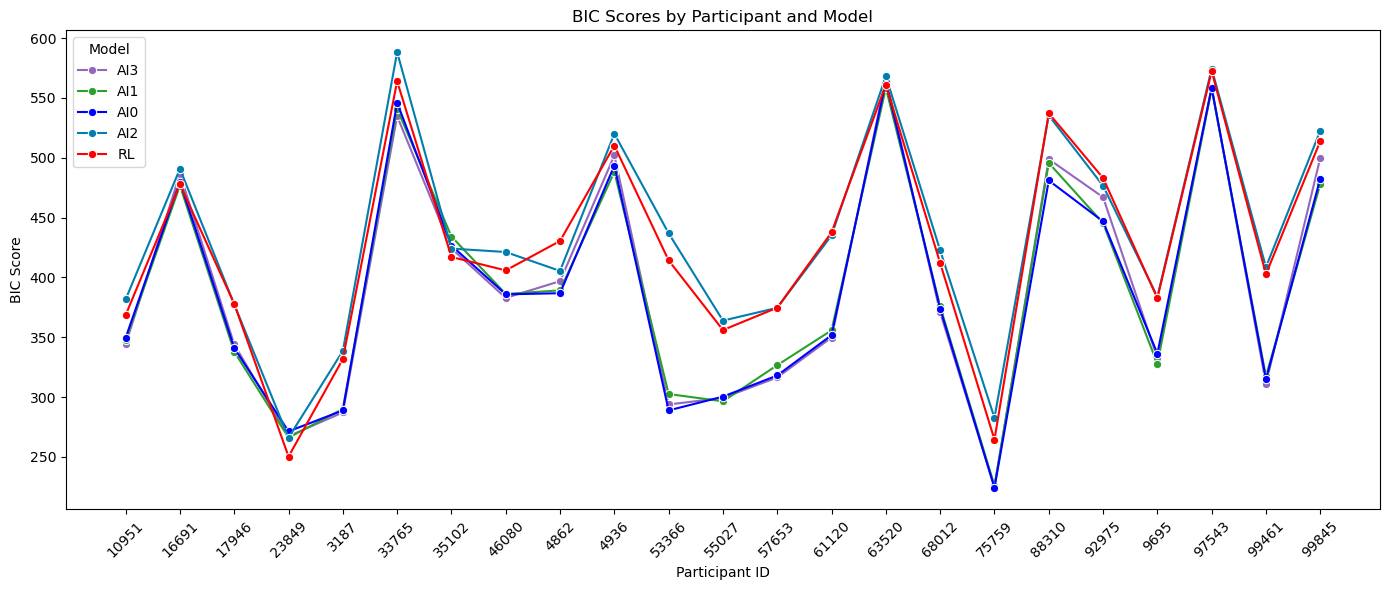

In [9]:
df_long_bic = pd.melt(df_BIC, 
                  id_vars='ParticipantID', 
                  value_vars=['RL', 'AI0', 'AI1', 'AI2', 'AI3'],
                  var_name='Model', 
                  value_name='BIC')

# Convert ParticipantID to string so it's treated as categorical
df_long_bic['ParticipantID'] = df_long_bic['ParticipantID'].astype(str)

# Optional: sort by ParticipantID string for cleaner plotting
df_long_bic = df_long_bic.sort_values(by='ParticipantID')

# Define a custom color palette
model_colors = {
    'RL': 'red',    # Blue
    'AI0': 'blue',   # Orange
    'AI1': '#2ca02c',   # Green
    'AI2': '#007fae',   # Red
    'AI3': '#9467bd'    # Purple
}

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_long_bic, x='ParticipantID', y='BIC', hue='Model', palette=model_colors, marker='o')
plt.xticks(rotation=45)
plt.title('BIC Scores by Participant and Model')
plt.xlabel('Participant ID')
plt.ylabel('BIC Score')
plt.tight_layout()
plt.legend(title='Model')
plt.show()

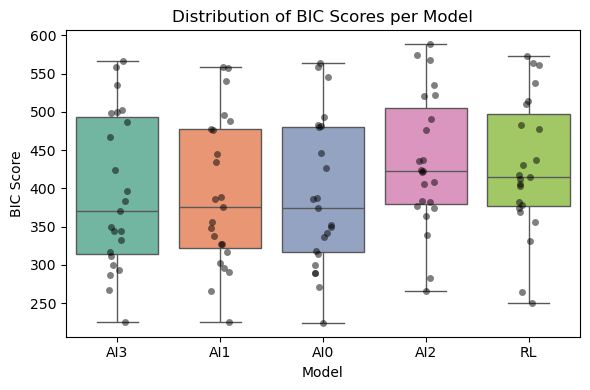

In [10]:
# Plot
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_long_bic, x='Model', y='BIC', hue='Model', palette='Set2', showfliers=False)  # `hue` parameter for coloring
sns.stripplot(data=df_long_bic, x='Model', y='BIC', color='black', alpha=0.5, jitter=True)
plt.title('Distribution of BIC Scores per Model')
plt.xlabel('Model')
plt.ylabel('BIC Score')
plt.tight_layout()
plt.show()

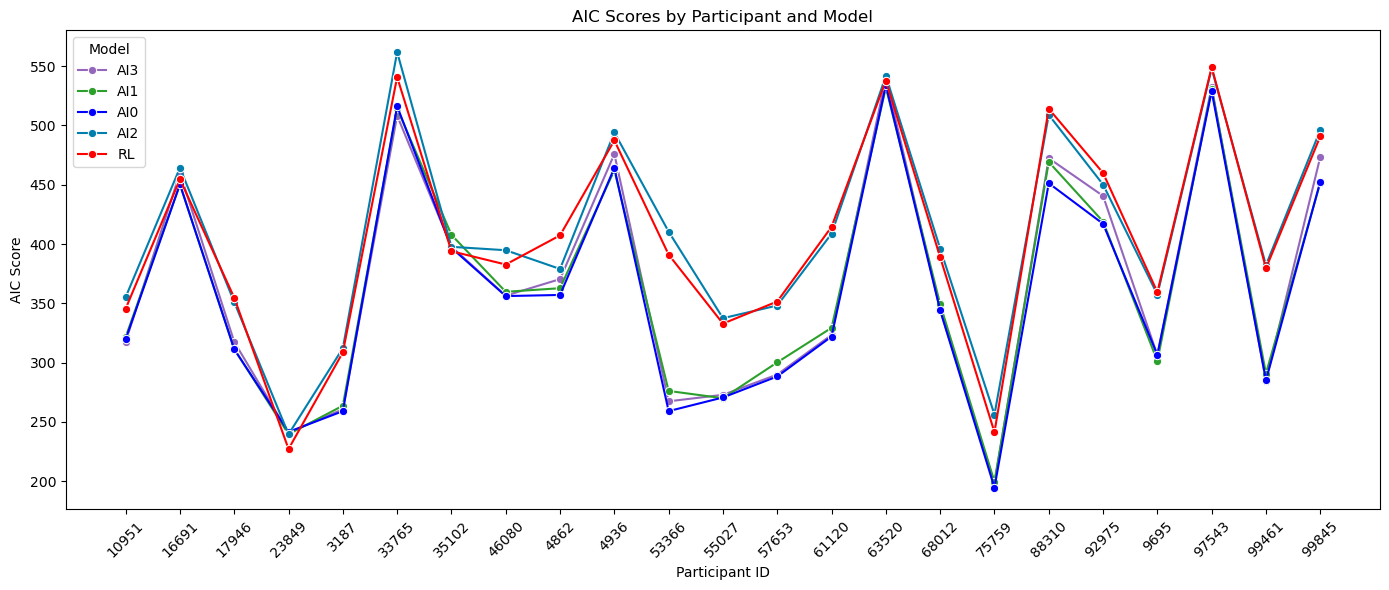

In [11]:
df_long_aic = pd.melt(df_AIC, 
                  id_vars='ParticipantID', 
                  value_vars=['RL', 'AI0', 'AI1', 'AI2', 'AI3'],
                  var_name='Model', 
                  value_name='AIC')

# Convert ParticipantID to string so it's treated as categorical
df_long_aic['ParticipantID'] = df_long_aic['ParticipantID'].astype(str)

# Optional: sort by ParticipantID string for cleaner plotting
df_long_aic = df_long_aic.sort_values(by='ParticipantID')

# Define a custom color palette
model_colors = {
    'RL': 'red',    # Blue
    'AI0': 'blue',   # Orange
    'AI1': '#2ca02c',   # Green
    'AI2': '#007fae',   # Red
    'AI3': '#9467bd'    # Purple
}

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_long_aic, x='ParticipantID', y='AIC', hue='Model', palette=model_colors, marker='o')
plt.xticks(rotation=45)
plt.title('AIC Scores by Participant and Model')
plt.xlabel('Participant ID')
plt.ylabel('AIC Score')
plt.tight_layout()
plt.legend(title='Model')
plt.show()

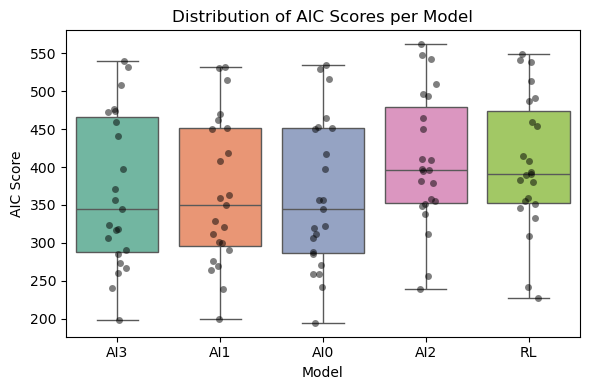

In [12]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_long_aic, x='Model', y='AIC', hue='Model', palette='Set2', showfliers=False)  # `hue` parameter for coloring
sns.stripplot(data=df_long_aic, x='Model', y='AIC', color='black', alpha=0.5, jitter=True)
plt.title('Distribution of AIC Scores per Model')
plt.xlabel('Model')
plt.ylabel('AIC Score')
plt.tight_layout()
plt.show()

# Compare performance of RL_ddm and AI_ddm models 

#### Download fitted parameters

In [15]:
fitted_params_dir = "../model_fitting/fitted_parameters/" + dataset 


df_RL_ddm_DRMlinear_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MRL_ddm_DRMlinear_n_starts" + str(n_starts) + ".csv")
df_AI_ddm0_DRMlinear_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MAI_ddm0_DRMlinear_n_starts" + str(n_starts) + ".csv")
df_AI_ddm1_DRMlinear_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MAI_ddm1_DRMlinear_n_starts" + str(n_starts) + ".csv")
df_AI_ddm2_DRMlinear_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MAI_ddm2_DRMlinear_n_starts" + str(n_starts) + ".csv")
df_AI_ddm3_DRMlinear_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MAI_ddm3_DRMlinear_n_starts" + str(n_starts) + ".csv")

df_RL_ddm_DRMsigmoid_single_v_mod_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MRL_ddm_DRMsigmoid_single_v_mod_n_starts" + str(n_starts) + ".csv")
df_AI_ddm0_DRMsigmoid_single_v_mod_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MAI_ddm0_DRMsigmoid_single_v_mod_n_starts" + str(n_starts) + ".csv")
df_AI_ddm1_DRMsigmoid_single_v_mod_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MAI_ddm1_DRMsigmoid_single_v_mod_n_starts" + str(n_starts) + ".csv")
df_AI_ddm2_DRMsigmoid_single_v_mod_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MAI_ddm2_DRMsigmoid_single_v_mod_n_starts" + str(n_starts) + ".csv")
df_AI_ddm3_DRMsigmoid_single_v_mod_fitted_params = pd.read_csv(fitted_params_dir + "/fitted_parameters_MAI_ddm3_DRMsigmoid_single_v_mod_n_starts" + str(n_starts) + ".csv")

#### Calculate number of parameters per 

In [16]:
RL_ddm_DRMlinear_k = len(df_RL_ddm_DRMlinear_fitted_params.columns) - 2
AI_ddm0_DRMlinear_k = len(df_AI_ddm0_DRMlinear_fitted_params.columns) - 2
AI_ddm1_DRMlinear_k = len(df_AI_ddm1_DRMlinear_fitted_params.columns) - 2
AI_ddm2_DRMlinear_k = len(df_AI_ddm2_DRMlinear_fitted_params.columns) - 2
AI_ddm3_DRMlinear_k = len(df_AI_ddm3_DRMlinear_fitted_params.columns) - 2

RL_ddm_DRMsigmoid_single_v_mod_k = len(df_RL_ddm_DRMsigmoid_single_v_mod_fitted_params.columns) - 2
AI_ddm0_DRMsigmoid_single_v_mod_k = len(df_AI_ddm0_DRMsigmoid_single_v_mod_fitted_params.columns) - 2
AI_ddm1_DRMsigmoid_single_v_mod_k = len(df_AI_ddm1_DRMsigmoid_single_v_mod_fitted_params.columns) - 2
AI_ddm2_DRMsigmoid_single_v_mod_k = len(df_AI_ddm2_DRMsigmoid_single_v_mod_fitted_params.columns) - 2
AI_ddm3_DRMsigmoid_single_v_mod_k = len(df_AI_ddm3_DRMsigmoid_single_v_mod_fitted_params.columns) - 2

#### Calculate BIC and AIC scores

In [ ]:
par_ids = df_RL_ddm_DRMlinear_fitted_params['ParticipantID'].values

column_names = ['ParticipantID',
                'RL_ddm_DRMlinear',  
                'AI_ddm0_DRMlinear', 
                'AI_ddm1_DRMlinear', 
                'AI_ddm2_DRMlinear', 
                'AI_ddm3_DRMlinear',
                #'RL_ddm_DRMsigmoid_single_v_mod',
                #'AI_ddm0_DRMsigmoid_single_v_mod', 
                #'AI_ddm1_DRMsigmoid_single_v_mod', 
                #'AI_ddm2_DRMsigmoid_single_v_mod', 
                #'AI_ddm3_DRMsigmoid_single_v_mod'
               ] 

df_BIC_ddm = pd.DataFrame(np.nan, index=range(len(par_ids)), columns=column_names)
df_BIC_ddm['ParticipantID'] = par_ids

df_AIC_ddm = pd.DataFrame(np.nan, index=range(len(par_ids)), columns=column_names)
df_AIC_ddm['ParticipantID'] = par_ids

df_LME_BIC_approx_ddm = pd.DataFrame(np.nan, index=range(len(par_ids)), columns=column_names)
df_LME_BIC_approx_ddm['ParticipantID'] = par_ids

df_LME_AIC_approx_ddm = pd.DataFrame(np.nan, index=range(len(par_ids)), columns=column_names)
df_LME_AIC_approx_ddm['ParticipantID'] = par_ids

for par in par_ids:

    df_par = df_behavioural[df_behavioural['ParticipantID'] == par]

    T = len(df_par) 
    
    # Identify bad trials
    if dataset == 'magic_carpet_2020':
        badtrials_rt1 = np.where((df_par['rt1'] < 0.1) | (df_par['rt1'] == -1) | df_par['rt1'].isna())[0]
        badtrials_rt2 = np.where((df_par['rt2'] < 0.1) | (df_par['rt2'] == -1) | df_par['rt2'].isna())[0]
    if dataset == 'magic_carpet_2023':
        badtrials_rt1 = np.where((df_par['rt1'] < 0.1) | (df_par['rt1'] == "") | df_par['rt1'].isna())[0]
        badtrials_rt2 = np.where((df_par['rt2'] < 0.1) | (df_par['rt2'] == "") | df_par['rt2'].isna())[0]
        
    badtrials = np.concatenate((badtrials_rt1, badtrials_rt2))
    badtrials = np.sort(np.unique(badtrials))

    RL_ddm_DRMlinear_NLL = df_RL_ddm_DRMlinear_fitted_params[df_RL_ddm_DRMlinear_fitted_params['ParticipantID'] == par]['NLL'].iloc[0]
    AI_ddm0_DRMlinear_NLL = df_AI_ddm0_DRMlinear_fitted_params[df_AI_ddm0_DRMlinear_fitted_params['ParticipantID'] == par]['NLL'].iloc[0]
    AI_ddm1_DRMlinear_NLL = df_AI_ddm1_DRMlinear_fitted_params[df_AI_ddm1_DRMlinear_fitted_params['ParticipantID'] == par]['NLL'].iloc[0]
    AI_ddm2_DRMlinear_NLL = df_AI_ddm2_DRMlinear_fitted_params[df_AI_ddm2_DRMlinear_fitted_params['ParticipantID'] == par]['NLL'].iloc[0]
    AI_ddm3_DRMlinear_NLL = df_AI_ddm3_DRMlinear_fitted_params[df_AI_ddm3_DRMlinear_fitted_params['ParticipantID'] == par]['NLL'].iloc[0]
    
    true_T = T - len(badtrials)
    
    df_BIC_ddm.loc[df_BIC_ddm['ParticipantID'] == par, 'RL_ddm_DRMlinear'] = ComputeBIC(RL_ddm_DRMlinear_k, true_T, RL_ddm_DRMlinear_NLL, True)    
    df_BIC_ddm.loc[df_BIC_ddm['ParticipantID'] == par, 'AI_ddm0_DRMlinear'] = ComputeBIC(AI_ddm0_DRMlinear_k, true_T, AI_ddm0_DRMlinear_NLL, True)  
    df_BIC_ddm.loc[df_BIC_ddm['ParticipantID'] == par, 'AI_ddm1_DRMlinear'] = ComputeBIC(AI_ddm1_DRMlinear_k, true_T, AI_ddm1_DRMlinear_NLL, True)  
    df_BIC_ddm.loc[df_BIC_ddm['ParticipantID'] == par, 'AI_ddm2_DRMlinear'] = ComputeBIC(AI_ddm2_DRMlinear_k, true_T, AI_ddm2_DRMlinear_NLL, True)  
    df_BIC_ddm.loc[df_BIC_ddm['ParticipantID'] == par, 'AI_ddm3_DRMlinear'] = ComputeBIC(AI_ddm3_DRMlinear_k, true_T, AI_ddm3_DRMlinear_NLL, True)  


    df_LME_BIC_approx_ddm.loc[df_LME_BIC_approx_ddm['ParticipantID'] == par, 'RL_ddm_DRMlinear'] = Compute_BIC_approx_LME(RL_ddm_DRMlinear_k, true_T, RL_ddm_DRMlinear_NLL, True)
    df_LME_BIC_approx_ddm.loc[df_LME_BIC_approx_ddm['ParticipantID'] == par, 'AI_ddm0_DRMlinear'] = Compute_BIC_approx_LME(AI_ddm0_DRMlinear_k, true_T, AI_ddm0_DRMlinear_NLL, True)
    df_LME_BIC_approx_ddm.loc[df_LME_BIC_approx_ddm['ParticipantID'] == par, 'AI_ddm1_DRMlinear'] = Compute_BIC_approx_LME(AI_ddm1_DRMlinear_k, true_T, AI_ddm1_DRMlinear_NLL, True)
    df_LME_BIC_approx_ddm.loc[df_LME_BIC_approx_ddm['ParticipantID'] == par, 'AI_ddm2_DRMlinear'] = Compute_BIC_approx_LME(AI_ddm2_DRMlinear_k, true_T, AI_ddm2_DRMlinear_NLL, True)
    df_LME_BIC_approx_ddm.loc[df_LME_BIC_approx_ddm['ParticipantID'] == par, 'AI_ddm3_DRMlinear'] = Compute_BIC_approx_LME(AI_ddm3_DRMlinear_k, true_T, AI_ddm3_DRMlinear_NLL, True)


    df_LME_AIC_approx_ddm.loc[df_LME_AIC_approx_ddm['ParticipantID'] == par, 'RL_ddm_DRMlinear'] = Compute_AIC_approx_LME(RL_ddm_DRMlinear_k, true_T, RL_ddm_DRMlinear_NLL, True)
    df_LME_AIC_approx_ddm.loc[df_LME_AIC_approx_ddm['ParticipantID'] == par, 'AI_ddm0_DRMlinear'] = Compute_AIC_approx_LME(AI_ddm0_DRMlinear_k, true_T, AI_ddm0_DRMlinear_NLL, True)
    df_LME_AIC_approx_ddm.loc[df_LME_AIC_approx_ddm['ParticipantID'] == par, 'AI_ddm1_DRMlinear'] = Compute_AIC_approx_LME(AI_ddm1_DRMlinear_k, true_T, AI_ddm1_DRMlinear_NLL, True)
    df_LME_AIC_approx_ddm.loc[df_LME_AIC_approx_ddm['ParticipantID'] == par, 'AI_ddm2_DRMlinear'] = Compute_AIC_approx_LME(AI_ddm2_DRMlinear_k, true_T, AI_ddm2_DRMlinear_NLL, True)
    df_LME_AIC_approx_ddm.loc[df_LME_AIC_approx_ddm['ParticipantID'] == par, 'AI_ddm3_DRMlinear'] = Compute_AIC_approx_LME(AI_ddm3_DRMlinear_k, true_T, AI_ddm3_DRMlinear_NLL, True)

    df_AIC_ddm.loc[df_AIC_ddm['ParticipantID'] == par, 'RL_ddm_DRMlinear'] = ComputeAIC(RL_ddm_DRMlinear_k, true_T, RL_ddm_DRMlinear_NLL, True)
    df_AIC_ddm.loc[df_AIC_ddm['ParticipantID'] == par, 'AI_ddm0_DRMlinear'] = ComputeAIC(AI_ddm0_DRMlinear_k, true_T, AI_ddm0_DRMlinear_NLL, True)
    df_AIC_ddm.loc[df_AIC_ddm['ParticipantID'] == par, 'AI_ddm1_DRMlinear'] = ComputeAIC(AI_ddm1_DRMlinear_k, true_T, AI_ddm1_DRMlinear_NLL, True)
    df_AIC_ddm.loc[df_AIC_ddm['ParticipantID'] == par, 'AI_ddm2_DRMlinear'] = ComputeAIC(AI_ddm2_DRMlinear_k, true_T, AI_ddm2_DRMlinear_NLL, True)
    df_AIC_ddm.loc[df_AIC_ddm['ParticipantID'] == par, 'AI_ddm3_DRMlinear'] = ComputeAIC(AI_ddm3_DRMlinear_k, true_T, AI_ddm3_DRMlinear_NLL, True)
   

# save LME file

df_LME_BIC_approx_ddm.to_csv(current_dir + '/LMEs_BIC_approx_ddm.csv', index=False)
df_LME_AIC_approx_ddm.to_csv(current_dir + '/LMEs_AIC_approx_ddm.csv', index=False)

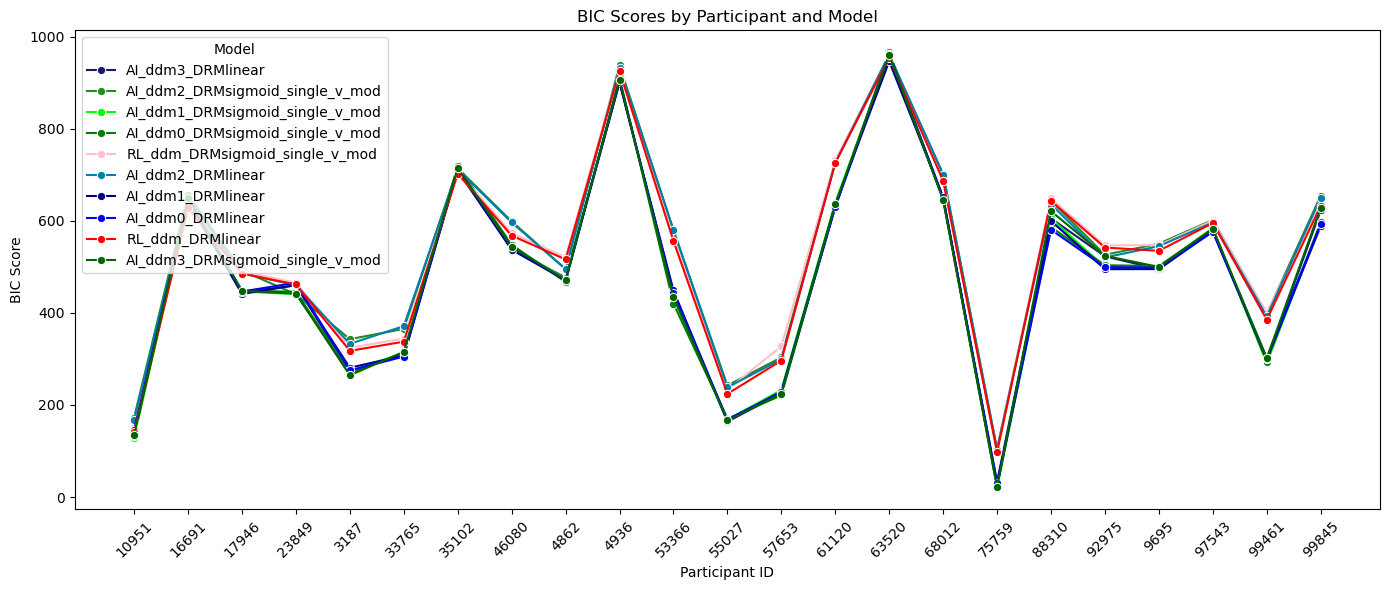

In [16]:
df_long_bic_ddm = pd.melt(df_BIC_ddm, 
                  id_vars='ParticipantID', 
                  value_vars=['RL_ddm_DRMlinear', 
                              'AI_ddm0_DRMlinear',
                              'AI_ddm1_DRMlinear', 
                              'AI_ddm2_DRMlinear', 
                              'AI_ddm3_DRMlinear', 
                              'RL_ddm_DRMsigmoid_single_v_mod',
                              'AI_ddm0_DRMsigmoid_single_v_mod',
                              'AI_ddm1_DRMsigmoid_single_v_mod',
                              'AI_ddm2_DRMsigmoid_single_v_mod',
                              'AI_ddm3_DRMsigmoid_single_v_mod'],
                  var_name='Model', 
                  value_name='BIC')

# Convert ParticipantID to string so it's treated as categorical
df_long_bic_ddm['ParticipantID'] = df_long_bic_ddm['ParticipantID'].astype(str)

# Optional: sort by ParticipantID string for cleaner plotting
df_long_bic_ddm = df_long_bic_ddm.sort_values(by='ParticipantID')

# Define a custom color palette
model_colors = {
    'RL_ddm_DRMlinear': 'red',  
    'AI_ddm0_DRMlinear': 'blue',   
    'AI_ddm1_DRMlinear': '#00008B',   # Dark blue
    'AI_ddm2_DRMlinear': '#007fae',   # Cyan blue
    'AI_ddm3_DRMlinear': '#191970' ,   # Midnight blue
    'RL_ddm_DRMsigmoid_single_v_mod': 'pink',   
    'AI_ddm0_DRMsigmoid_single_v_mod': 'green', 
    'AI_ddm1_DRMsigmoid_single_v_mod': '#00FF00',  # Lime
    'AI_ddm2_DRMsigmoid_single_v_mod': '#228B22', # Forest green
    'AI_ddm3_DRMsigmoid_single_v_mod': '#006400', # dark green
}

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_long_bic_ddm, x='ParticipantID', y='BIC', hue='Model', palette=model_colors, marker='o')
plt.xticks(rotation=45)
plt.title('BIC Scores by Participant and Model')
plt.xlabel('Participant ID')
plt.ylabel('BIC Score')
plt.tight_layout()
plt.legend(title='Model')
plt.show()

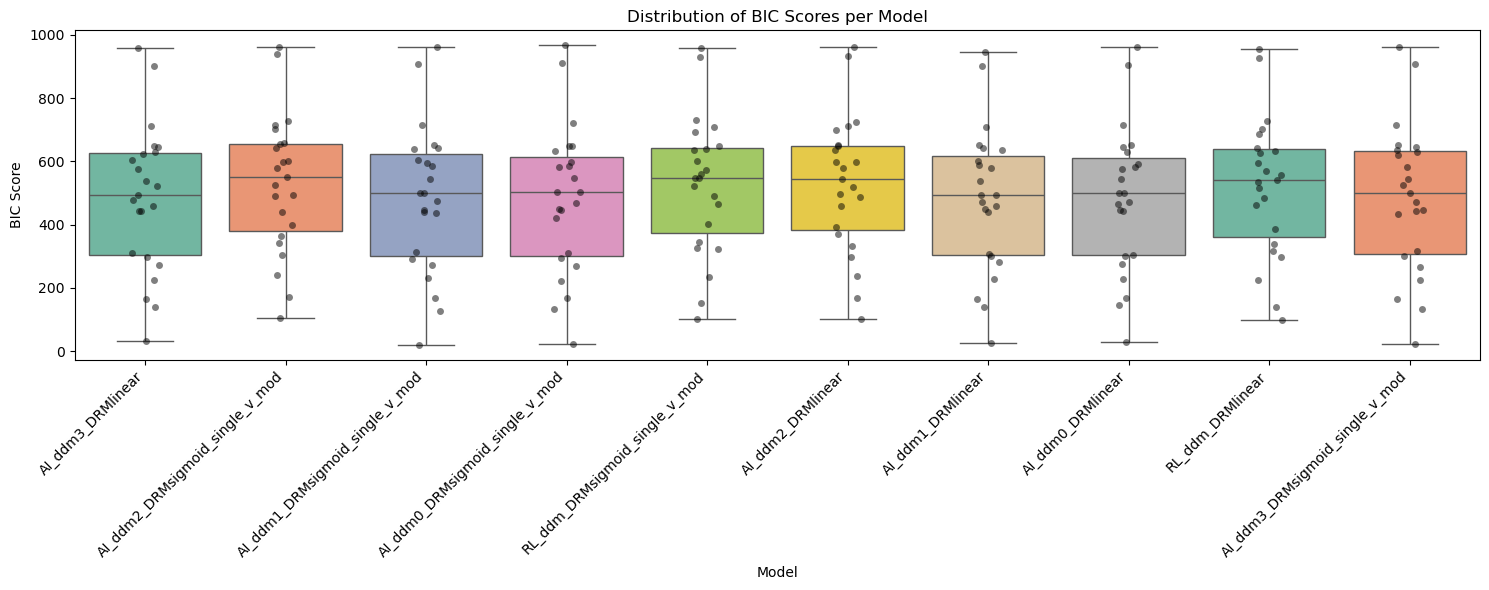

In [17]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_long_bic_ddm, x='Model', y='BIC', hue='Model', palette='Set2', showfliers=False)  # `hue` parameter for coloring
sns.stripplot(data=df_long_bic_ddm, x='Model', y='BIC', color='black', alpha=0.5, jitter=True)
plt.title('Distribution of BIC Scores per Model')
plt.xlabel('Model')
plt.ylabel('BIC Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

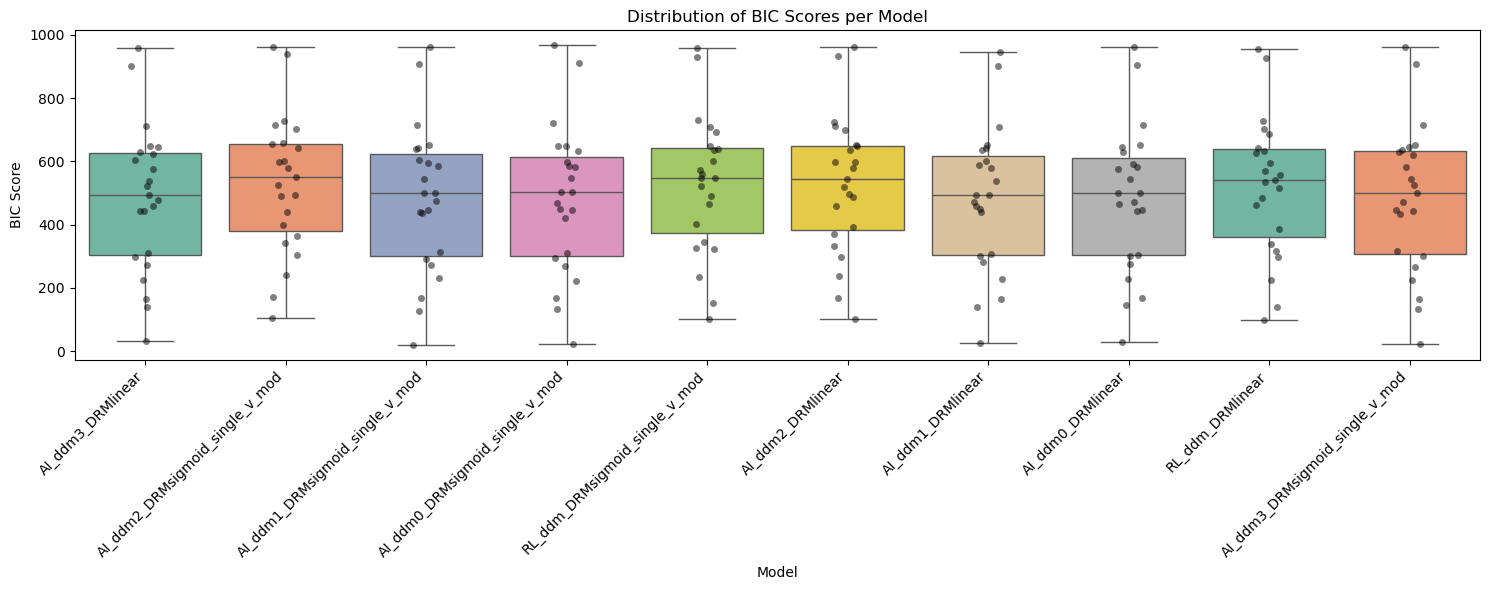

In [18]:
plt.figure(figsize=(15, 6))
sns.boxplot(
    data=df_long_bic_ddm,
    x='Model',
    y='BIC',
    hue='Model',
    palette='Set2',
    showfliers=False
)
sns.stripplot(
    data=df_long_bic_ddm,
    x='Model',
    y='BIC',
    color='black',
    alpha=0.5,
    jitter=True
)

plt.title('Distribution of BIC Scores per Model')
plt.xlabel('Model')
plt.ylabel('BIC Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


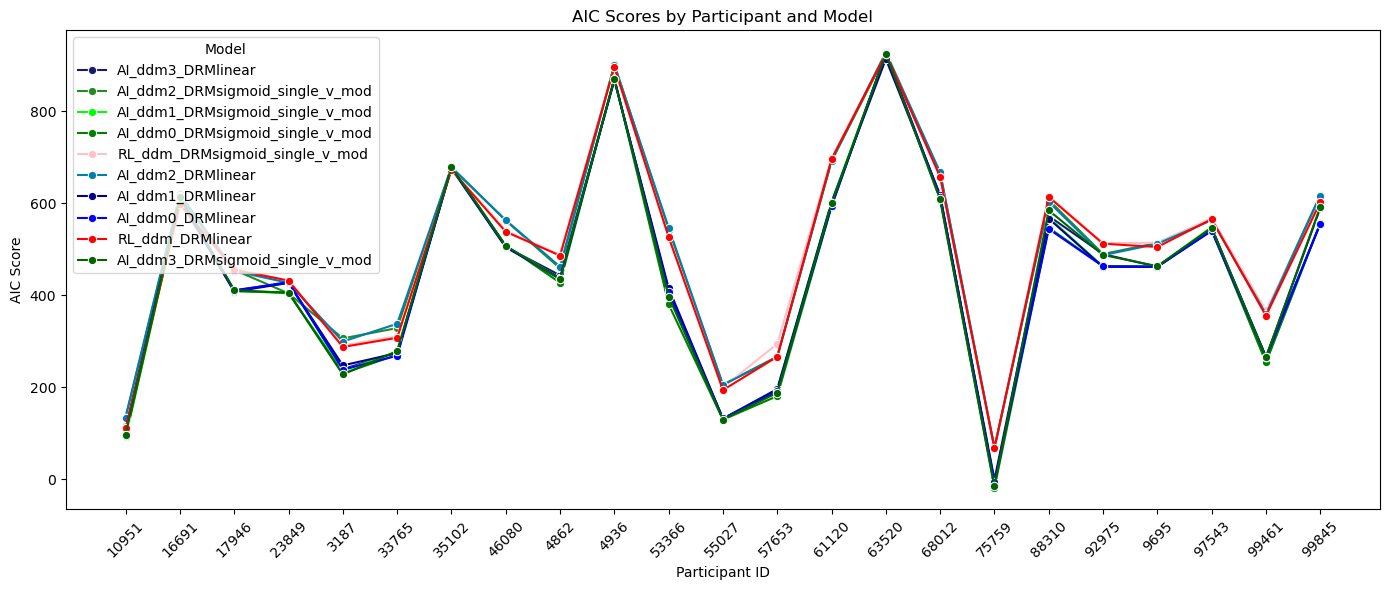

In [19]:
df_long_aic_ddm = pd.melt(df_AIC_ddm, 
                  id_vars='ParticipantID', 
                  value_vars=['RL_ddm_DRMlinear', 
                              'AI_ddm0_DRMlinear',
                              'AI_ddm1_DRMlinear', 
                              'AI_ddm2_DRMlinear', 
                              'AI_ddm3_DRMlinear', 
                              'RL_ddm_DRMsigmoid_single_v_mod',
                              'AI_ddm0_DRMsigmoid_single_v_mod',
                              'AI_ddm1_DRMsigmoid_single_v_mod',
                              'AI_ddm2_DRMsigmoid_single_v_mod',
                              'AI_ddm3_DRMsigmoid_single_v_mod'],
                  var_name='Model', 
                  value_name='AIC')

# Convert ParticipantID to string so it's treated as categorical
df_long_aic_ddm['ParticipantID'] = df_long_aic_ddm['ParticipantID'].astype(str)

# Optional: sort by ParticipantID string for cleaner plotting
df_long_aic_ddm = df_long_aic_ddm.sort_values(by='ParticipantID')


# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_long_aic_ddm, x='ParticipantID', y='AIC', hue='Model', palette=model_colors, marker='o')
plt.xticks(rotation=45)
plt.title('AIC Scores by Participant and Model')
plt.xlabel('Participant ID')
plt.ylabel('AIC Score')
plt.tight_layout()
plt.legend(title='Model')
plt.show()

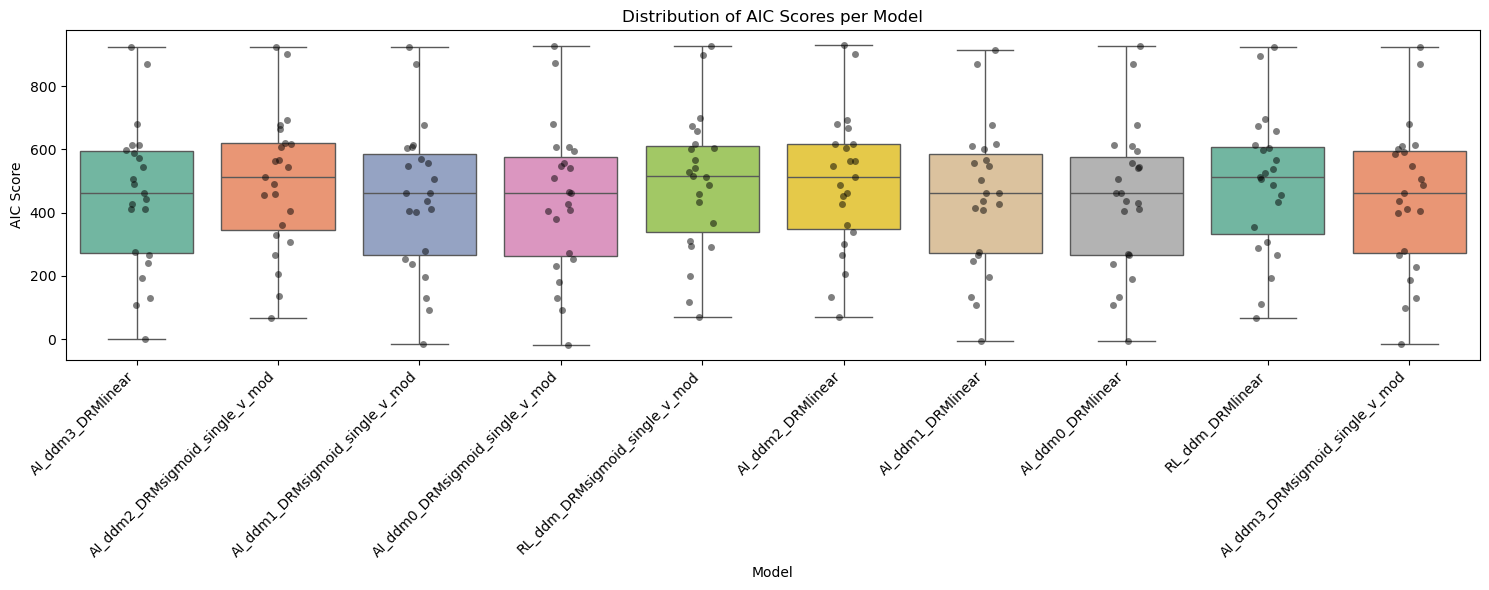

In [20]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_long_aic_ddm, x='Model', y='AIC', hue='Model', palette='Set2', showfliers=False)  # `hue` parameter for coloring
sns.stripplot(data=df_long_aic_ddm, x='Model', y='AIC', color='black', alpha=0.5, jitter=True)
plt.title('Distribution of AIC Scores per Model')
plt.xlabel('Model')
plt.ylabel('AIC Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check correlation in parameters between models with and without DDMs decision rules

#### Comparing fitted parameters of AI_ddm1 and AI1:

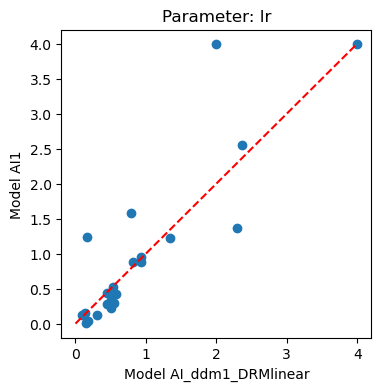

In [31]:
plt.figure(figsize=(4, 4)) 

max_x = max(df_AI_ddm1_DRMlinear_fitted_params['Fitted_lr'])
max_y = max(df_AI1_fitted_params['Fitted_lr'])

max_val = max(max_x, max_y)

plt.title("Parameter: lr")
plt.plot([0, max_val], [0, max_val], 'r--') 
plt.scatter(df_AI_ddm1_DRMlinear_fitted_params['Fitted_lr'],df_AI1_fitted_params['Fitted_lr'])
plt.ylabel("Model AI1")
plt.xlabel("Model AI_ddm1_DRMlinear")
plt.show()

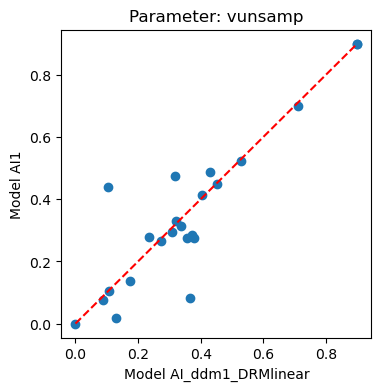

In [32]:
plt.figure(figsize=(4, 4)) 

max_x = max(df_AI_ddm1_DRMlinear_fitted_params['Fitted_vunsamp'])
max_y = max(df_AI1_fitted_params['Fitted_vunsamp'])

max_val = max(max_x, max_y)
plt.title("Parameter: vunsamp")
plt.plot([0, max_val], [0, max_val ], 'r--') 
plt.scatter(df_AI_ddm1_DRMlinear_fitted_params['Fitted_vunsamp'],df_AI1_fitted_params['Fitted_vunsamp'])
plt.ylabel("Model AI1")
plt.xlabel("Model AI_ddm1_DRMlinear")
plt.show()

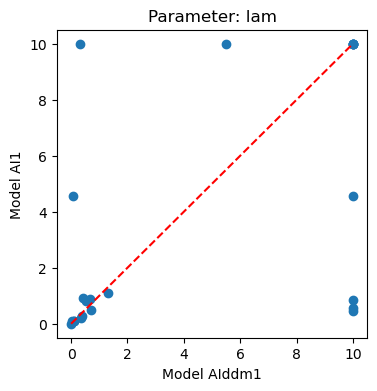

In [33]:
plt.figure(figsize=(4, 4)) 

max_x = max(df_AI_ddm1_DRMlinear_fitted_params['Fitted_lam'])
max_y = max(df_AI1_fitted_params['Fitted_lam'])

max_val = max(max_x, max_y)
plt.title("Parameter: lam")
plt.plot([0, max_val], [0, max_val], 'r--') 
plt.scatter(df_AI_ddm1_DRMlinear_fitted_params['Fitted_lam'],df_AI1_fitted_params['Fitted_lam'])
plt.ylabel("Model AI1")
plt.xlabel("Model AIddm1")
#plt.xlim(0,2)
#plt.ylim(0,2)
plt.show()

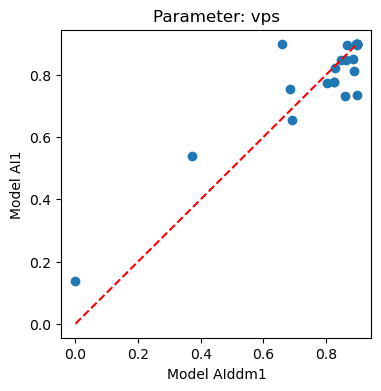

In [34]:
plt.figure(figsize=(4, 4)) 

max_x = max(df_AI_ddm1_DRMlinear_fitted_params['Fitted_vps'])
max_y = max(df_AI1_fitted_params['Fitted_vps'])
max_val = max(max_x, max_y)
plt.title("Parameter: vps")
plt.plot([0, max_val], [0, max_val ], 'r--') 
plt.scatter(df_AI_ddm1_DRMlinear_fitted_params['Fitted_vps'],df_AI1_fitted_params['Fitted_vps'])
plt.ylabel("Model AI1")
plt.xlabel("Model AIddm1")
#plt.xlim(0,2)
#plt.ylim(0,2)
plt.show()

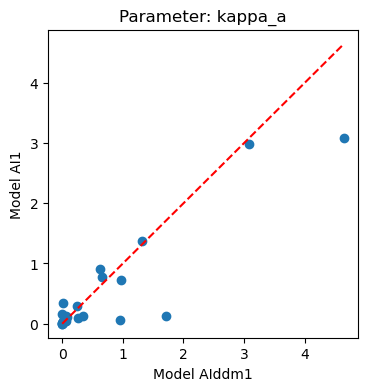

In [35]:
plt.figure(figsize=(4, 4)) 

max_x = max(df_AI_ddm1_DRMlinear_fitted_params['Fitted_kappa_a'])
max_y = max(df_AI1_fitted_params['Fitted_kappa_a'])

max_val = max(max_x, max_y)
plt.title("Parameter: kappa_a")
plt.plot([0, max_val], [0, max_val ], 'r--') 
plt.scatter(df_AI_ddm1_DRMlinear_fitted_params['Fitted_kappa_a'],df_AI1_fitted_params['Fitted_kappa_a'])
plt.ylabel("Model AI1")
plt.xlabel("Model AIddm1")
#plt.xlim(0,2)
#plt.ylim(0,2)
plt.show()

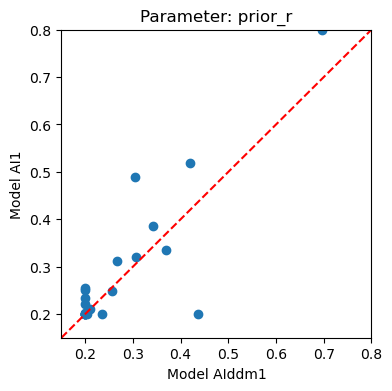

In [37]:
plt.figure(figsize=(4, 4)) 

max_x = max(df_AI_ddm1_DRMlinear_fitted_params['Fitted_prior_r'])
max_y = max(df_AI1_fitted_params['Fitted_prior_r'])
plt.title("Parameter: prior_r")

max_val = max(max_x, max_y)
plt.plot([0.15, max_val], [0.15, max_val], 'r--') 
plt.scatter(df_AI_ddm1_DRMlinear_fitted_params['Fitted_prior_r'],df_AI1_fitted_params['Fitted_prior_r'])
plt.ylabel("Model AI1")
plt.xlabel("Model AIddm1")

plt.ylim(0.15,max([max_x,max_y]))
plt.xlim(0.15,max([max_x,max_y]))
plt.show()

## Results of Bayesian Model Procedure (BMS)

- AI0 = $\text{AIF}_{\text{FULL}}$
- AI1 = $\text{AIF}_{\text{NSD}}$
- AI2 = $\text{AIF}_{\text{NUD}}$
- AI3 = $\text{AIF}_{\text{NPS}}$

#### BMS for Standard Models

In [19]:
categories = [
    r'$HRL$',
    r'$AIF_{\text{FULL}}$',
    r'$AIF_{\text{NSD}}$',
    r'$AIF_{\text{NUD}}$',
    r'$AIF_{\text{NPS}}$'  
]

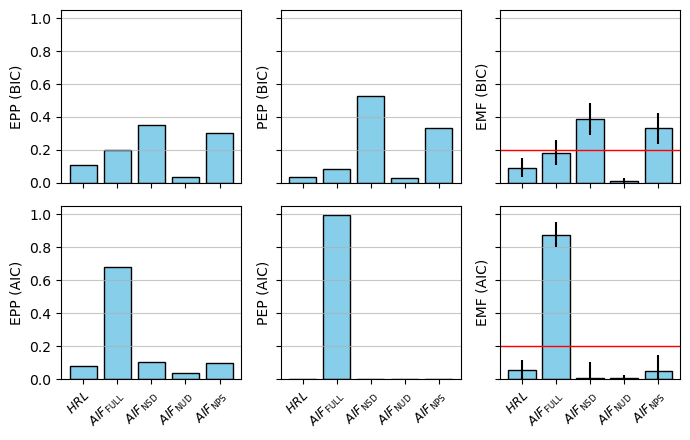

In [20]:
df_bms_bic_approx_standard_models = pd.read_csv('bms_results_bic_approx_standard_models.csv')
df_bms_aic_approx_standard_models = pd.read_csv('bms_results_aic_approx_standard_models.csv')

x_positions = np.arange(len(categories))
y_ticks = np.arange(0, 1.01, 0.2)
y_positions = np.arange(len(y_ticks))

fig, ax = plt.subplots(2, 3, figsize=(7,4.5))

values = df_bms_bic_approx_standard_models['Expected Posterior Probability'].values
ax[0, 0].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[0, 0].set_ylabel('EPP (BIC)', fontsize=10)
ax[0, 0].set_xticks(x_positions)                
ax[0, 0].tick_params(axis='x', labelbottom=False)
ax[0, 0].set_ylim(0, 1.05)
ax[0, 0].set_yticks(y_ticks)
ax[0, 0].grid(axis='y', linestyle='-', alpha=0.7)


values = df_bms_bic_approx_standard_models['ProtectedExceedanceProbability'].values
ax[0, 1].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[0, 1].set_ylabel('PEP (BIC)', fontsize=10)
ax[0, 1].set_xticks(x_positions)                 
ax[0, 1].tick_params(axis='x', labelbottom=False)
ax[0, 1].set_yticks(y_positions)            
ax[0, 1].tick_params(axis='y', labelleft=False)
ax[0, 1].set_ylim(0, 1.05)
ax[0, 1].set_yticks(y_ticks)
ax[0, 1].grid(axis='y', linestyle='-', alpha=0.7)

values = df_bms_bic_approx_standard_models['EstimatedModelFrequency'].values
std_values = np.sqrt(df_bms_bic_approx_standard_models['EstimatedModelFrequencyVariance'].values)
ax[0, 2].bar(x_positions, values, yerr=std_values, color='skyblue', edgecolor='black')
ax[0, 2].set_ylabel('EMF (BIC)', fontsize=10)
ax[0, 2].set_xticks(x_positions)               
ax[0, 2].tick_params(axis='x', labelbottom=False)
ax[0, 2].set_yticks(y_positions)            
ax[0, 2].tick_params(axis='y', labelleft=False)
ax[0, 2].axhline(y=0.2, color='red', linestyle='-', linewidth=1)
ax[0, 2].set_ylim(0, 1.05)
ax[0, 2].set_yticks(y_ticks)
ax[0, 2].grid(axis='y', linestyle='-', alpha=0.7)

values = df_bms_aic_approx_standard_models['Expected Posterior Probability'].values
ax[1, 0].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[1, 0].set_ylabel('EPP (AIC)', fontsize=10)
#ax[1, 0].set_title('BMS(AIC)', fontsize=14)
ax[1, 0].set_xticks(x_positions, categories, rotation=45, ha="right", fontsize=9,rotation_mode="anchor")
ax[1, 0].set_ylim(0, 1.05)
ax[1, 0].set_yticks(y_ticks)
ax[1, 0].grid(axis='y', linestyle='-', alpha=0.7)


values = df_bms_aic_approx_standard_models['ProtectedExceedanceProbability'].values
ax[1, 1].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[1, 1].set_ylabel('PEP (AIC)', fontsize=10)
#ax[1, 1].set_title('BMS (AIC)', fontsize=14)
ax[1, 1].set_xticks(x_positions, categories, rotation=45, ha="right", fontsize=9,rotation_mode="anchor")
ax[1, 1].set_ylim(0, 1.05)
ax[1, 1].set_yticks(y_ticks)
ax[1, 1].tick_params(axis='y', labelleft=False)
ax[1, 1].grid(axis='y', linestyle='-', alpha=0.7)

values = df_bms_aic_approx_standard_models['EstimatedModelFrequency'].values
std_values = np.sqrt(df_bms_bic_approx_standard_models['EstimatedModelFrequencyVariance'].values)
ax[1, 2].bar(x_positions, values, yerr=std_values, color='skyblue', edgecolor='black')
ax[1, 2].set_ylabel('EMF (AIC)', fontsize=10)
#ax[1, 2].set_title('BMS (AIC)', fontsize=14)
ax[1, 2].axhline(y=0.2, color='red', linestyle='-', linewidth=1)
ax[1, 2].set_xticks(x_positions, categories, rotation=45, fontsize=9, ha="right",va="top",rotation_mode="anchor")#ha="right", va="top",  fontsize=9)
ax[1, 2].set_ylim(0, 1.05)
ax[1, 2].set_yticks(y_ticks)
#ax[1, 2].set_yticks(y_positions)            
ax[1, 2].tick_params(axis='y', labelleft=False)
ax[1, 2].grid(axis='y', linestyle='-', alpha=0.7)

plt.tight_layout() 

plot_filename = f"standard_model_comparison.png" 
output_dir = f"../paper_figures/model_comparison/" 
       
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
       
full_plot_path = os.path.join(output_dir, plot_filename)

plt.savefig(full_plot_path, dpi=300, bbox_inches='tight')
plt.show()

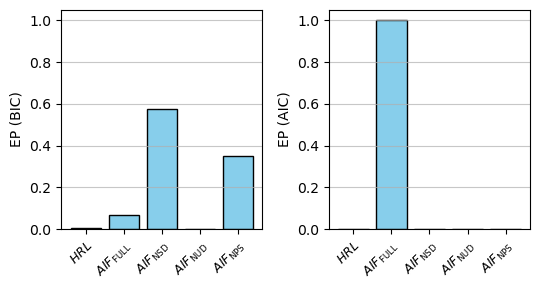

In [21]:
df_bms_bic_approx_standard_models = pd.read_csv('bms_results_bic_approx_standard_models.csv')
df_bms_aic_approx_standard_models = pd.read_csv('bms_results_aic_approx_standard_models.csv')
x_positions = np.arange(len(categories))


fig, ax = plt.subplots(1,2, figsize=(5.5,3))

values = df_bms_bic_approx_standard_models['ExceedanceProbability'].values
ax[0].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[0].set_ylabel('EP (BIC)', fontsize=10)
ax[0].set_xticks(x_positions, categories, rotation=45, fontsize=9, ha="right",va="top",rotation_mode="anchor")
ax[0].set_ylim(0, 1.05)
ax[0].set_yticks(y_ticks)
ax[0].grid(axis='y', linestyle='-', alpha=0.7)

values = df_bms_aic_approx_standard_models['ExceedanceProbability'].values
ax[1].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[1].set_ylabel('EP (AIC)', fontsize=10)
ax[1].set_xticks(x_positions, categories, rotation=45, fontsize=9, ha="right",va="top",rotation_mode="anchor")
ax[1].set_ylim(0, 1.05)
ax[1].set_yticks(y_ticks)
ax[1].grid(axis='y', linestyle='-', alpha=0.7)

plt.tight_layout() 
plt.show()

#### BMS for DDM Models

In [22]:
categories_ddm = [
    r'$HRL-DDM$',
    r'$AIF-DDM_{\text{FULL}}$',
    r'$AIF-DDM_{\text{NSD}}$',
    r'$AIF-DDM_{\text{NUD}}$',
    r'$AIF-DDM_{\text{NPS}}$'  
]

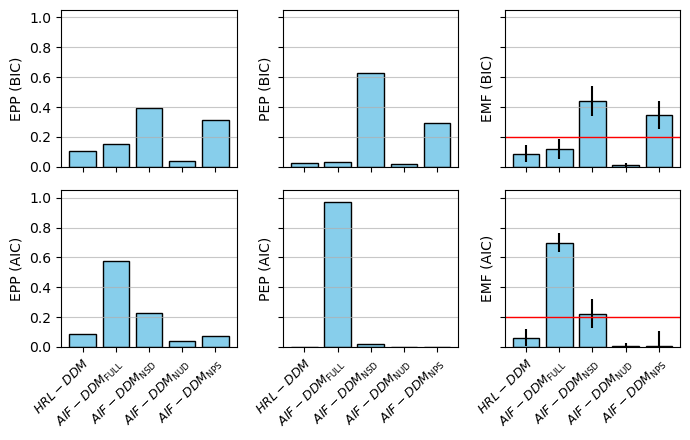

In [23]:
df_bms_bic_approx_ddm_models = pd.read_csv('bms_results_bic_approx_ddm_models.csv')
df_bms_aic_approx_ddm_models = pd.read_csv('bms_results_aic_approx_ddm_models.csv')

x_positions = np.arange(len(categories_ddm))
y_ticks = np.arange(0, 1.01, 0.2)
y_positions = np.arange(len(y_ticks))

fig, ax = plt.subplots(2, 3, figsize=(7,4.5))

values = df_bms_bic_approx_ddm_models['Expected Posterior Probability'].values
ax[0, 0].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[0, 0].set_ylabel('EPP (BIC)', fontsize=10)
#ax[0, 0].set_title('BMS(BIC)', fontsize=14)
#ax[0, 0].set_xticks(x_positions, categories_ddm, rotation=45, ha="right", fontsize=9)
ax[0, 0].set_xticks(x_positions)                 # <<< DRAWS THE TICK MARKS
ax[0, 0].tick_params(axis='x', labelbottom=False)
ax[0, 0].set_ylim(0, 1.05)
ax[0, 0].set_yticks(y_ticks)
ax[0, 0].grid(axis='y', linestyle='-', alpha=0.7)


values = df_bms_bic_approx_ddm_models['ProtectedExceedanceProbability'].values
ax[0, 1].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[0, 1].set_ylabel('PEP (BIC)', fontsize=10)
#ax[0, 1].set_title('BMS (BIC)', fontsize=14)
#ax[0, 1].set_xticks(x_positions, categories_ddm, rotation=45, ha="right", fontsize=9)
ax[0, 1].set_xticks(x_positions)                 
ax[0, 1].tick_params(axis='x', labelbottom=False)
ax[0, 1].set_yticks(y_positions)            
ax[0, 1].tick_params(axis='y', labelleft=False)
ax[0, 1].set_ylim(0, 1.05)
ax[0, 1].set_yticks(y_ticks)
ax[0, 1].grid(axis='y', linestyle='-', alpha=0.7)

values = df_bms_bic_approx_ddm_models['EstimatedModelFrequency'].values
std_values = np.sqrt(df_bms_bic_approx_ddm_models['EstimatedModelFrequencyVariance'].values)
ax[0, 2].bar(x_positions, values, yerr=std_values, color='skyblue', edgecolor='black')
ax[0, 2].set_ylabel('EMF (BIC)', fontsize=10)
#ax[0, 2].set_title('BMS (BIC)', fontsize=14)
ax[0, 2].set_xticks(x_positions)                 # <<< DRAWS THE TICK MARKS
ax[0, 2].tick_params(axis='x', labelbottom=False)
ax[0, 2].set_yticks(y_positions)            
ax[0, 2].tick_params(axis='y', labelleft=False)
ax[0, 2].axhline(y=0.2, color='red', linestyle='-', linewidth=1)
#ax[0, 2].set_xticks(x_positions, categories_ddm, rotation=45, ha="right", fontsize=9)
ax[0, 2].set_ylim(0, 1.05)
ax[0, 2].set_yticks(y_ticks)
ax[0, 2].grid(axis='y', linestyle='-', alpha=0.7)

values = df_bms_aic_approx_ddm_models['Expected Posterior Probability'].values
ax[1, 0].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[1, 0].set_ylabel('EPP (AIC)', fontsize=10)
#ax[1, 0].set_title('BMS(AIC)', fontsize=14)
ax[1, 0].set_xticks(x_positions, categories_ddm, rotation=45, ha="right", fontsize=9,rotation_mode="anchor")
ax[1, 0].set_ylim(0, 1.05)
ax[1, 0].set_yticks(y_ticks)
ax[1, 0].grid(axis='y', linestyle='-', alpha=0.7)


values = df_bms_aic_approx_ddm_models['ProtectedExceedanceProbability'].values
ax[1, 1].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[1, 1].set_ylabel('PEP (AIC)', fontsize=10)
#ax[1, 1].set_title('BMS (AIC)', fontsize=14)
ax[1, 1].set_xticks(x_positions, categories_ddm, rotation=45, ha="right", fontsize=9,rotation_mode="anchor")
ax[1, 1].set_ylim(0, 1.05)
ax[1, 1].set_yticks(y_ticks)
ax[1, 1].tick_params(axis='y', labelleft=False)
ax[1, 1].grid(axis='y', linestyle='-', alpha=0.7)

values = df_bms_aic_approx_ddm_models['EstimatedModelFrequency'].values
std_values = np.sqrt(df_bms_bic_approx_ddm_models['EstimatedModelFrequencyVariance'].values)
ax[1, 2].bar(x_positions, values, yerr=std_values, color='skyblue', edgecolor='black')
ax[1, 2].set_ylabel('EMF (AIC)', fontsize=10)
#ax[1, 2].set_title('BMS (AIC)', fontsize=14)
ax[1, 2].axhline(y=0.2, color='red', linestyle='-', linewidth=1)
ax[1, 2].set_xticks(x_positions, categories_ddm, rotation=45, fontsize=9, ha="right",va="top",rotation_mode="anchor")#ha="right", va="top",  fontsize=9)
ax[1, 2].set_ylim(0, 1.05)
ax[1, 2].set_yticks(y_ticks)
#ax[1, 2].set_yticks(y_positions)            
ax[1, 2].tick_params(axis='y', labelleft=False)
ax[1, 2].grid(axis='y', linestyle='-', alpha=0.7)

plt.tight_layout() 

plot_filename = f"ddm_model_comparison.png" 
output_dir = f"../paper_figures/model_comparison/" 
       
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
       
full_plot_path = os.path.join(output_dir, plot_filename)

plt.savefig(full_plot_path, dpi=300, bbox_inches='tight')
plt.show()

In [14]:
df_bms_bic_approx_ddm_models

,ModelName,Expected Posterior Probability,ExceedanceProbability,ProtectedExceedanceProbability,EstimatedModelFrequency,EstimatedModelFrequencyVariance
0,RL_ddm_DRMlinear,0.107535,0.004192,0.023218,0.087664,0.003199
1,AI_ddm0_DRMlinear,0.150477,0.016030,0.033905,0.118245,0.004171
2,AI_ddm1_DRMlinear,0.390786,0.675588,0.629378,0.438580,0.009849
3,AI_ddm2_DRMlinear,0.036799,0.000116,0.019538,0.008346,0.000331
4,AI_ddm3_DRMlinear,0.314405,0.304074,0.293962,0.347165,0.009066


In [24]:
df_bms_aic_approx_ddm_models

,ModelName,Expected Posterior Probability,ExceedanceProbability,ProtectedExceedanceProbability,EstimatedModelFrequency,EstimatedModelFrequencyVariance
0,RL_ddm_DRMlinear,0.086951,0.000229,0.002191,0.060691,0.002280
1,AI_ddm0_DRMlinear,0.573510,0.982074,0.974392,0.698783,0.008419
2,AI_ddm1_DRMlinear,0.229787,0.017571,0.019363,0.223659,0.006945
3,AI_ddm2_DRMlinear,0.037501,0.000014,0.001978,0.008356,0.000331
4,AI_ddm3_DRMlinear,0.072250,0.000112,0.002076,0.008511,0.000338


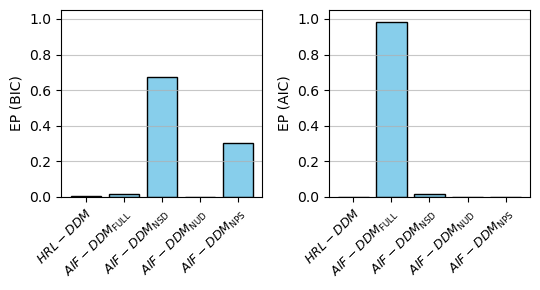

In [25]:
df_bms_bic_approx_ddm_models = pd.read_csv('bms_results_bic_approx_ddm_models.csv')
df_bms_aic_approx_ddm_models = pd.read_csv('bms_results_aic_approx_ddm_models.csv')
x_positions = np.arange(len(categories_ddm))


fig, ax = plt.subplots(1,2, figsize=(5.5,3))

values = df_bms_bic_approx_ddm_models['ExceedanceProbability'].values
ax[0].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[0].set_ylabel('EP (BIC)', fontsize=10)
ax[0].set_xticks(x_positions, categories_ddm, rotation=45, fontsize=9, ha="right",va="top",rotation_mode="anchor")
ax[0].set_ylim(0, 1.05)
ax[0].set_yticks(y_ticks)
ax[0].grid(axis='y', linestyle='-', alpha=0.7)

values = df_bms_aic_approx_ddm_models['ExceedanceProbability'].values
ax[1].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[1].set_ylabel('EP (AIC)', fontsize=10)
ax[1].set_xticks(x_positions, categories_ddm, rotation=45, fontsize=9, ha="right",va="top",rotation_mode="anchor")
ax[1].set_ylim(0, 1.05)
ax[1].set_yticks(y_ticks)
ax[1].grid(axis='y', linestyle='-', alpha=0.7)

plt.tight_layout() 
plt.show()

## DDM Moded Family Comparisons 

In [26]:
categories_ddm_families = [
    r'$RL-DDM_{\text{f}}$',
    r'$AIF-DDM_{\text{f}}$' 
]

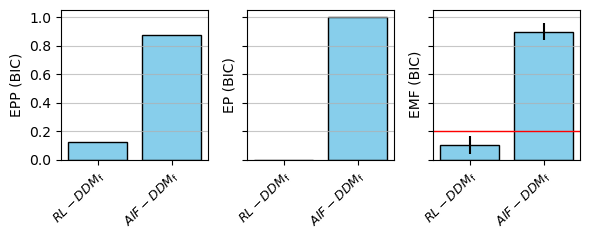

In [27]:
x_positions = np.arange(len(categories_ddm_families))
y_ticks = np.arange(0, 1.01, 0.2)
y_positions = np.arange(len(y_ticks))

fig, ax = plt.subplots(1,3, figsize=(6,2.5))

values = np.array([0.1236, 0.8764])
ax[0].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[0].set_ylabel('EPP (BIC)', fontsize=10)
ax[0].set_xticks(x_positions, categories_ddm_families, rotation=45, fontsize=9, ha="right",va="top",rotation_mode="anchor")
ax[0].set_ylim(0, 1.05)
ax[0].set_yticks(y_ticks)
ax[0].grid(axis='y', linestyle='-', alpha=0.7)


values = np.array([0, 1])
ax[1].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[1].set_ylabel('EP (BIC)', fontsize=10)
ax[1].set_xticks(x_positions, categories_ddm_families, rotation=45, fontsize=9, ha="right",va="top",rotation_mode="anchor")
ax[1].set_yticks(y_positions)            
ax[1].tick_params(axis='y', labelleft=False)
ax[1].set_ylim(0, 1.05)
ax[1].set_yticks(y_ticks)
ax[1].grid(axis='y', linestyle='-', alpha=0.7)

values = np.array([0.1026,0.8974])
std_values = np.sqrt(np.array([0.0037,0.0037]))

ax[2].bar(x_positions, values, yerr=std_values, color='skyblue', edgecolor='black')
ax[2].set_ylabel('EMF (BIC)', fontsize=10)
ax[2].set_xticks(x_positions, categories_ddm_families, rotation=45, fontsize=9, ha="right",va="top",rotation_mode="anchor")
ax[2].set_yticks(y_positions)            
ax[2].tick_params(axis='y', labelleft=False)
ax[2].axhline(y=0.2, color='red', linestyle='-', linewidth=1)
ax[2].set_ylim(0, 1.05)
ax[2].set_yticks(y_ticks)
ax[2].grid(axis='y', linestyle='-', alpha=0.7)

plt.tight_layout() 

plot_filename = f"ddm_model_families_comparison_bic.png" 
output_dir = f"../paper_figures/model_comparison/" 
       
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
       
full_plot_path = os.path.join(output_dir, plot_filename)

plt.savefig(full_plot_path, dpi=300, bbox_inches='tight')
plt.show()

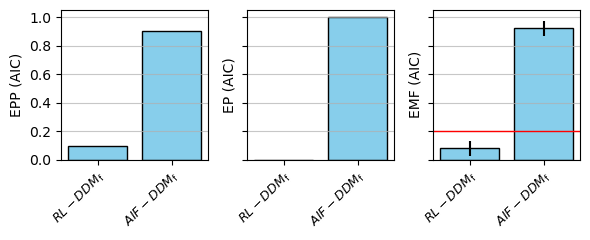

In [28]:
x_positions = np.arange(len(categories_ddm_families))
y_ticks = np.arange(0, 1.01, 0.2)
y_positions = np.arange(len(y_ticks))

fig, ax = plt.subplots(1,3, figsize=(6,2.5))

values = np.array([0.0985, 0.9015])
ax[0].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[0].set_ylabel('EPP (AIC)', fontsize=10)
ax[0].set_xticks(x_positions, categories_ddm_families, rotation=45, fontsize=9, ha="right",va="top",rotation_mode="anchor")
ax[0].set_ylim(0, 1.05)
ax[0].set_yticks(y_ticks)
ax[0].grid(axis='y', linestyle='-', alpha=0.7)


values = np.array([0, 1])
ax[1].bar(x_positions, values, color='skyblue', edgecolor='black')
ax[1].set_ylabel('EP (AIC)', fontsize=10)
ax[1].set_xticks(x_positions, categories_ddm_families, rotation=45, fontsize=9, ha="right",va="top",rotation_mode="anchor")
ax[1].set_yticks(y_positions)            
ax[1].tick_params(axis='y', labelleft=False)
ax[1].set_ylim(0, 1.05)
ax[1].set_yticks(y_ticks)
ax[1].grid(axis='y', linestyle='-', alpha=0.7)

values = np.array([0.0777,0.9223])
std_values = np.sqrt(np.array([0.0029,0.0029]))

ax[2].bar(x_positions, values, yerr=std_values, color='skyblue', edgecolor='black')
ax[2].set_ylabel('EMF (AIC)', fontsize=10)
ax[2].set_xticks(x_positions, categories_ddm_families, rotation=45, fontsize=9, ha="right",va="top",rotation_mode="anchor")
ax[2].set_yticks(y_positions)            
ax[2].tick_params(axis='y', labelleft=False)
ax[2].axhline(y=0.2, color='red', linestyle='-', linewidth=1)
ax[2].set_ylim(0, 1.05)
ax[2].set_yticks(y_ticks)
ax[2].grid(axis='y', linestyle='-', alpha=0.7)

plt.tight_layout() 

plot_filename = f"ddm_model_families_comparison_aic.png" 
output_dir = f"../paper_figures/model_comparison/" 
       
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
       
full_plot_path = os.path.join(output_dir, plot_filename)

plt.savefig(full_plot_path, dpi=300, bbox_inches='tight')
plt.show()